# Topic Modeling

---

Topic Modeling (Modelagem de tópicos) é uma área de PLN (Processamento de Linguagem Natural) que foca em dividir os textos em composições de tópicos.

Por exemplo, considere os textos abaixo:

1)
*Edson Arantes do Nascimento (Três Corações, 23 de outubro de 1940), mais conhecido como Pelé, é um ex-futebolista brasileiro que atuava como atacante. Ele é amplamente considerado como um dos maiores atletas de todos os tempos.* - [Wikipedia](https://pt.wikipedia.org/wiki/Pel%C3%A9)

2)
*Jogar futebol é considerado um exercício completo, porque os movimentos intensos e variados através de corridas, chutes e giros, ajudam a manter o corpo sempre saudável, sendo uma ótima opção também para mulheres, porque ajuda na prevenção da osteoporose e sintomas da TPM.* - [TuaSaúde](https://www.tuasaude.com/beneficios-do-futebol/)

Podemos considerar que o tópico do texto 1 é *Futebol*, enquanto os tópicos do texto 2 são *Futebol* e *Saúde*.

Além disso, podemos atribuir porcentagens de participação em cada tópico, e considerar que o texto 1 tem 100% em *Futebol* e o texto 2 com 50% em cada tópico.

Os algoritmos de modelagem de tópicos pertencem a classe não-supervisionada, isto é, não dependem de anotações humanas sobre os textos para aprender.

Ao invés disso, eles se baseiam em análises matemáticas/estatísticas sobre a distribuição dos dados para 'atribui-los' a algum tópico.


Neste notebook, vamos nos aprofundar no tema utilizando um dataset de Leis Brasileiras.

### Importando os dados

O primeiro passo é importar os dados que iremos utilizar.

Realizaremos nossos experimentos em um conjunto de dados contendo as Ementas de [Leis Ordinarias Brasileiras](http://www4.planalto.gov.br/legislacao/portal-legis/legislacao-1/leis-ordinarias#:~:text=S%C3%A3o%20as%20leis%20t%C3%ADpicas%2C%20ou,Federal%20presentes%20durante%20a%20vota%C3%A7%C3%A3o.)
dos anos de 2002 a 2020

In [110]:
import pandas as pd

In [111]:
data = pd.read_csv('leis_ordinarias_2002_2020.csv')
data.head()

,lei,ementa,ano
0,"Lei nº 14.116, de 31.12.2020\nPublicada no DOU...",Dispõe sobre as diretrizes para a elaboração e...,2020
1,"Lei nº 14.115, de 29.12.2020\nPublicada no DOU...",Estabelece o aumento da participação da União ...,2020
2,"Lei nº 14.114, de 29.12.2020\nPublicada no DOU...",Abre aos Orçamentos Fiscal e da Seguridade Soc...,2020
3,"Lei nº 14.113, de 25.12.2020\nPublicada no DOU...",Regulamenta o Fundo de Manutenção e Desenvolvi...,2020
4,"Lei nº 14.112, de 24.12.2020\nPublicada no DOU...","Altera as Leis n os 11.101, de 9 de fevereiro ...",2020


In [112]:
print( f"Número de textos - {len(data)}" )

Número de textos - 3716


Selecionando os textos

In [113]:
textos = data['ementa']
textos.head()

0    Dispõe sobre as diretrizes para a elaboração e...
1    Estabelece o aumento da participação da União ...
2    Abre aos Orçamentos Fiscal e da Seguridade Soc...
3    Regulamenta o Fundo de Manutenção e Desenvolvi...
4    Altera as Leis n os 11.101, de 9 de fevereiro ...
Name: ementa, dtype: object

Alguns exemplos aleatórios do formato de uma ementa

In [114]:
print(textos[0], end='\n\n')
print(textos[16], end='\n\n')
print(textos[40], end='\n\n')

Dispõe sobre as diretrizes para a elaboração e a execução da Lei Orçamentária de 2021 e dá outras providências.    Mensagem de veto

Abre aos Orçamentos Fiscal e da Seguridade Social da União, em favor dos Ministérios da Saúde, do Desenvolvimento Regional e da Cidadania, crédito suplementar no valor de R$ 3.181.000,00, para reforço de dotações constantes da Lei Orçamentária vigente.

Altera as Leis n os 9.440, de 14 de março de 1997, 9.826, de 23 de agosto de 1999, e 7.827, de 27 de setembro de 1989, a fim de prorrogar incentivos fiscais para o desenvolvimento regional, na forma que especifica.



### Pré processamento 


A etapa de pré processamento é uma das mais importantes, é nela que decidimos o formato final que o texto terá antes de ser transformado em números.

Vamos focar especialmente em técnicas de *Normalização textual*, mas tenha em mente que várias outras técnicas existem e depende bastante da aplicação a ser desenvolvida quais delas iremos utilizar.

Técnicas de normalização textual focam principalmente em reduzir a variância existente em termos e palavras de um texto a estruturas mais simples.

Por exemplo, as palavras 'casa', 'casas' e 'casinha' referem-se fundamentalmente à mesma estrutura, talvez seja interessante para o algoritmo que não haja distinção entre elas. Por isso, podemos trocar todas elas por uma única palavra, como 'casa'.

No nosso dataset, temos várias leis que citam valores monetários (como R$ 100.000,25), como todos referem-se a valores em dinheiro, podemos reduzir todos eles ao termo <DINHEIRO>.

In [115]:
import re

def sub_dinheiro(texto):
  regex_pattern = r'[R][$][ ]\d{1,3}(?:\.\d{3})*?,\d{2}'
  return re.sub(regex_pattern, '<DINHEIRO>', texto )

print( sub_dinheiro('Abre orçamento de R$ 332.212,20') )
print( sub_dinheiro('Abre orçamento com valor de R$ 214,12') )
print( sub_dinheiro('R$ 1.000.000,25 é o prêmio do BBB') )

Abre orçamento de <DINHEIRO>
Abre orçamento com valor de <DINHEIRO>
<DINHEIRO> é o prêmio do BBB


Vamos realizar o seguinte processamento:

- Substituir os valores em dinheiro pelo termo [DINHEIRO]
- Substituir números por [NUMERO] 
- Colocar todo o texto em *lowercase* (NÃO -> não)
- Remover as 'stopwords', palavras que consideramos não agregar significado ao texto, como preposições e artigos.

In [116]:
import nltk
nltk.download('stopwords')

def sub_num(texto):
  regex_pattern = r'\d+([.]\d+){0,1}'
  return re.sub(regex_pattern, '<NUMERO>', texto )

## Substituindo os valores em Dinheiro
textos = textos.apply( sub_dinheiro )

## Substituindo os valores de Números
textos = textos.apply( sub_num )

## Colocando os textos em lowercase
textos = textos.apply( lambda x: x.lower() )

## Selecionando as stopwords, serão removidas mais à frente com auxílio do 
## vetorizador
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Visualizando alguns exemplos

In [117]:
print(textos[0], end='\n\n')
print(textos[16], end='\n\n')
print(textos[40], end='\n\n')

dispõe sobre as diretrizes para a elaboração e a execução da lei orçamentária de <numero> e dá outras providências.    mensagem de veto

abre aos orçamentos fiscal e da seguridade social da união, em favor dos ministérios da saúde, do desenvolvimento regional e da cidadania, crédito suplementar no valor de <dinheiro>, para reforço de dotações constantes da lei orçamentária vigente.

altera as leis n os <numero>, de <numero> de março de <numero>, <numero>, de <numero> de agosto de <numero>, e <numero>, de <numero> de setembro de <numero>, a fim de prorrogar incentivos fiscais para o desenvolvimento regional, na forma que especifica.



### Feature Extraction



Feature extraction ou vectorization é a etapa de transformar o conteúdo textual em valores numéricos.

Para as técnicas de Topic Modeling que usaremos aqui, é necessário que tenhamos uma representação esparsa dos textos, onde cada dimensão do vetor representa uma palavra.

Decidimos utilizar o método TF-IDF para vetorização dos nossos textos.

Não vamos nos aprofundar muito nos detalhes do método, mas, em resumo, ele é capaz de construir um vetor de tamanho $K$ para cada um dos textos da base, onde cada dimensão do vetor representa uma palavra do vocabulário.
Mais sobre, em [[1]](https://pt.wikipedia.org/wiki/Tf%E2%80%93idf)[[2]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Vamos utilizar a versão do Scikit-learn para realizar a vetorização.

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords)
# max_features=1000 significa que só iremos considerar as 1000 palavras mais frequentes
# pode ser entendido como uma técnica de normalização textual
# Realiza também a remoção de stopwords

textos_vec = vectorizer.fit_transform(textos).todense()

Como podemos ver abaixo, a cada um dos 3716 textos foi associado um vetor de dimensão 1000.

In [119]:
textos_vec.shape

(3716, 1000)

## Aplicando Topic Modeling com NMF

No nosso exemplo, vamos utilizar o método NMF (Non-negative Matrix Factorization), que, em resumo, divide uma matriz principal, que em nosso caso é o conjunto de vetores representando os dados, no produto de duas outras matrizes menores não-negativas.

<center> 
$X \approx W\cdot H$ 
</center>

Uma dessas matrizes representa os 'tópicos' dos nossos textos. 

Vale salientar que os algoritmos trabalham apenas com números, eles apenas realizam os cálculos e encontram resultados puramente numéricos. Cabe a nós, ao final do treinamento, ler e avalair o que os resultados significam e que 'tópicos' eles representariam.

Para nosso exemplo, vamos tentar dividir as Leis Brasileiras em 10 tópicos.

In [120]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=10, random_state=214)
nmf.fit(textos_vec)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=214, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

## Visualizando os resultados

Vamos visualizar os resultados do algoritmo. Para acessar os 'tópicos' precisamos utilizar o atributo `components_`.

In [121]:
nmf.components_

array([[0.00177945, 0.        , 0.13030419, ..., 0.04582828, 0.00370211,
        0.04743212],
       [0.08773   , 0.82688422, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00854509, ..., 0.00550929, 0.        ,
        0.        ],
       ...,
       [0.        , 0.21587808, 0.00207236, ..., 0.01362773, 0.45402566,
        0.01386964],
       [0.        , 0.41350848, 0.        , ..., 0.        , 0.01835851,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00094428,
        0.        ]])

Como podemos ver, o atributo é uma matriz numérica. Sua dimensão pode ser vista abaixo:

In [122]:
nmf.components_.shape

(10, 1000)

O modelo criou 10 tópicos, cada um deles com 1000 componentes, que é o tamanho original do nosso conjunto de dados.

Os seus valores podem ser interpretado da seguinte forma:

- Em cada tópico, o modelo atribui um valor numérico para cada palavra do vocabulário.
- As palavras que compõem um tópico são aquelas com os maiores valores numéricos.

Dito isto, vamos visualizar as palavras de cada tópico:

In [123]:
# Mapeamento para as palavras do vocabulário
feature_names = vectorizer.get_feature_names()

# Número de palavras mais importantes que estamos considerando
n_top_palavras = 15

for i, topic_vec in enumerate(nmf.components_):
    print(i, end=' ')
    for id in topic_vec.argsort()[-1:-n_top_palavras-1:-1]:
        print(feature_names[id], end=', ')
    print()

0 numero, lei, altera, nº, dezembro, art, julho, leis, setembro, janeiro, maio, decreto, código, agosto, junho, 
1 vigente, reforço, orçamentária, suplementar, dotações, constantes, união, fiscal, orçamento, crédito, abre, favor, dinheiro, valor, lei, 
2 dia, institui, nacional, combate, outubro, ser, ano, integração, conscientização, prevenção, comemorado, data, semana, luta, política, 
3 especifica, especial, fins, crédito, favor, abre, dinheiro, valor, ministério, união, orçamento, fiscal, extraordinário, fim, transportes, 
4 outras, providências, dá, dispõe, sobre, mensagem, veto, elaboração, diretrizes, execução, federal, exercício, profissão, lei, universidade, 
5 trabalho, tribunal, cargos, criação, região, regional, quadro, pessoal, funções, secretaria, provimento, efetivo, comissionadas, dispõe, comissão, 
6 estado, rodovia, br, denomina, trecho, município, rio, viaduto, cidade, confere, título, capital, sul, ponte, aeroporto, 
7 social, seguridade, orçamentos, ministérios, di

Para visualizar melhor essas palavras, façamos a visualização da word cloud.

In [124]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

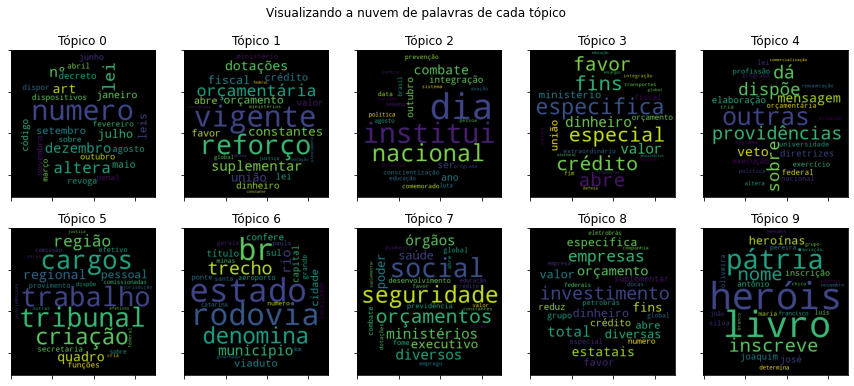

In [153]:
# Número de palavras mais importantes que estamos considerando
n_top_palavras = 25

mask = np.array(Image.open("black_circle.jpg"))
fig, axs = plt.subplots(nrows=2,
                        ncols=5, figsize=(15,6))
axs = axs.flatten()

fig.suptitle('Visualizando a nuvem de palavras de cada tópico')

for ax in axs:
  ax.axes.xaxis.set_ticklabels([])
  ax.axes.yaxis.set_ticklabels([])

for i, topic_vec in enumerate(nmf.components_):
  freq = dict()
  wordcloud_img = WordCloud(width=600, height=400, 
                            mask=mask, background_color='black',
                            random_state=214)

  for id in topic_vec.argsort()[-1:-n_top_palavras-1:-1]:
    freq[ feature_names[id] ] = topic_vec[id]
    
  wordcloud_img.generate_from_frequencies(freq)
  axs[i].imshow(wordcloud_img)
  axs[i].set_title(f'Tópico {i}')
  

Como podemos ver acima, nossos tópicos gerados automaticamente realmente fazem algum sentido interpretável.

- O tópico 9 aparenta falar sobre inscrição de nomes no livro de heróis da pátria. 
- O tópico 8, sobre investimentos a empresas. 
- O tópico 0 aparenta falar de leis de maneira geral, com as datas que foram criadas.
- O tópico 2 fala sobre a criação de datas comemorativas.

Por fim, podemos também visualizar a quais tópicos pertencem a um texto em específico. 

In [147]:
def topicos_texto(id):
  ## Selecionando textos
  texto = textos[id]
  texto_vec = textos_vec[id]
  topic_vec = nmf.transform( texto_vec )[0]
  print("\nTexto:")
  print(texto)
  print( "Tópico i - pontuação\n====================" )
  for i, topic_valor in enumerate(topic_vec):
    print( f"Tópico {i} - {topic_valor.round(2)}" )

In [151]:
## Visualizandoa alguns textos
topicos_texto(16)
topicos_texto(40)
topicos_texto(1234)


Texto:
abre aos orçamentos fiscal e da seguridade social da união, em favor dos ministérios da saúde, do desenvolvimento regional e da cidadania, crédito suplementar no valor de <dinheiro>, para reforço de dotações constantes da lei orçamentária vigente.
Tópico i - pontuação
Tópico 0 - 0.0
Tópico 1 - 0.13
Tópico 2 - 0.0
Tópico 3 - 0.0
Tópico 4 - 0.0
Tópico 5 - 0.02
Tópico 6 - 0.0
Tópico 7 - 0.14
Tópico 8 - 0.0
Tópico 9 - 0.0

Texto:
altera as leis n os <numero>, de <numero> de março de <numero>, <numero>, de <numero> de agosto de <numero>, e <numero>, de <numero> de setembro de <numero>, a fim de prorrogar incentivos fiscais para o desenvolvimento regional, na forma que especifica.
Tópico i - pontuação
Tópico 0 - 0.14
Tópico 1 - 0.0
Tópico 2 - 0.0
Tópico 3 - 0.02
Tópico 4 - 0.0
Tópico 5 - 0.01
Tópico 6 - 0.0
Tópico 7 - 0.0
Tópico 8 - 0.0
Tópico 9 - 0.0

Texto:
dispõe sobre a denominação do novo prédio da administração da faculdade de direito, no campus da universidade federal do amazo

## Conclusão

Neste notebook, exploramos alguns aspectos do topic modeling com exemplos práticos em um dataset de leis brasileiras.

Topic modeling é uma poderosa ferramenta para nos ajudar a entender e explorar nosso conjunto de dados, em nosso exemplo, conseguimos com sucesso sair de um conjunto desconhecido de milhares de documentos para uma ordenação mais amigável ao ser humano.

